<a href="https://colab.research.google.com/github/volfenstein1/dida_segmentation_task/blob/main/3_dida_segmentation_task_final_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the previous notebooks I established an initial baseline for the task at hand, and performed experimentation to try and determine optimal choices for the model.

In this notebook, I perform a final training pass with these choices.

I make the deliberate choice to **train on the entire dataset**, without separating an evaluation set. This would be an abnormal choice in a more controlled setting. I make an exception for this case, since the dataset is so small, to try and eke out a bit more performance from the model.

I also have one final tool we can use to try and improve model performance: **data augmentation** of our very limited dataset. We use the python library [AlbumentationsX](https://github.com/albumentations-team/AlbumentationsX).

I will also train the model without any augmentations as a control. To make sure the comparisons are fair, one should in principle use a constant compute budget for each training; hence if the augmentations increase the size of the dataset x10, we should increase the number of epochs in the control x10.

The final choices for the model are:
- Model Encoder and Encoder Weights: mit_b5 / imagenet
- Model Architecture: UPerNet
- Optimizer: Adam
- Learning Rate: 1e-4
- Loss Function: Combined Loss (Focal + LogDice)

In what follows, I train:

- A control model for 1000 epochs.
- A model where the dataset has been augmented x10 times for 100 epochs.


In [ ]:
# @title
%%capture
!pip install torchvision;
!pip install segmentation-models-pytorch;
!pip install albumentationsx;

In [ ]:
# @title
print('Python imports')
from google.colab import drive
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss, SoftBCEWithLogitsLoss, SoftCrossEntropyLoss, JaccardLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, f1_score
import albumentations as A

Python imports


In [ ]:
# @title
print('Mount Google Drive folders contained the training data')
drive.mount("/mnt/drive")

images_path = "/mnt/drive/MyDrive/dida/images"
labels_path = "/mnt/drive/MyDrive/dida/labels"
to_predict = "/mnt/drive/MyDrive/dida/to_predict"

Mount Google Drive folders contained the training data
Drive already mounted at /mnt/drive; to attempt to forcibly remount, call drive.mount("/mnt/drive", force_remount=True).


# Data augmentations

In [ ]:
# @title
print('Define the tranformations from the AlbumentationsX library')
transform = A.Compose([
    # Crop and resize the image / label
    A.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0), p=1.0),

    # Randomly rotate / flip the image / label
    A.D4(p=1.0),

    # Apply affine transformation to the image / label
    A.Affine(scale=(0.9, 1.1), translate_percent=0.1, rotate=(-30, 30), shear=(-10, 10), p=0.7),

    # Apply color transforms
    # The albumentations library only applies this to the image
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),

    # Apply dropouts
    # The albumentations library applies this to both image and label
    A.CoarseDropout(num_holes_range=[1,2], hole_height_range=[0.1, 0.2], hole_width_range=[0.1, 0.2], p=0.2),
])

Define the tranformations from the AlbumentationsX library


In [ ]:
# @title
print('Define the Segmentation Dataset, allowing for possible transformations and multplied by number of augmentations')
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, augmentations=1):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.augmentations = augmentations
        self.common_filenames = sorted(f for f in os.listdir(image_dir) if f in os.listdir(label_dir))

    def __len__(self):
        return len(self.common_filenames) * self.augmentations

    def __getitem__(self, idx):
        folder_idx = idx % len(self.common_filenames)
        image_path = os.path.join(self.image_dir, self.common_filenames[folder_idx])
        label_path = os.path.join(self.label_dir, self.common_filenames[folder_idx])

        image_pil = Image.open(image_path).convert("RGB")
        label_pil = Image.open(label_path).convert("L")

        image_np = np.array(image_pil)
        label_np = np.array(label_pil)

        if self.transform:
            augmented = self.transform(image=image_np, mask=label_np)
            image_np = augmented['image']
            label_np = augmented['mask']

        image_tensor = ToTensor()(image_np)
        label_tensor = ToTensor()(label_np)

        return image_tensor, label_tensor

Define the Segmentation Dataset, allowing for possible transformations and multplied by number of augmentations


In [ ]:
# @title
print('Load the Dataset, with augmentations and without')
ds = SegmentationDataset(images_path, labels_path, transform=transform, augmentations=10)
ds_control = SegmentationDataset(images_path, labels_path, transform=None, augmentations=1)

print("Size of the augmented dataset:", len(ds))
print("Size of the control, unaugmented dataset:", len(ds_control))

aug_loader = DataLoader(ds, batch_size=32, shuffle=True)
control_loader = DataLoader(ds_control, batch_size=24, shuffle=False)

Load the Dataset, with augmentations and without
Size of the augmented dataset: 240
Size of the control, unaugmented dataset: 24


Check the structure of the augmented dataset
Image batch shape:  torch.Size([32, 3, 256, 256])
Label batch shape:  torch.Size([32, 1, 256, 256])


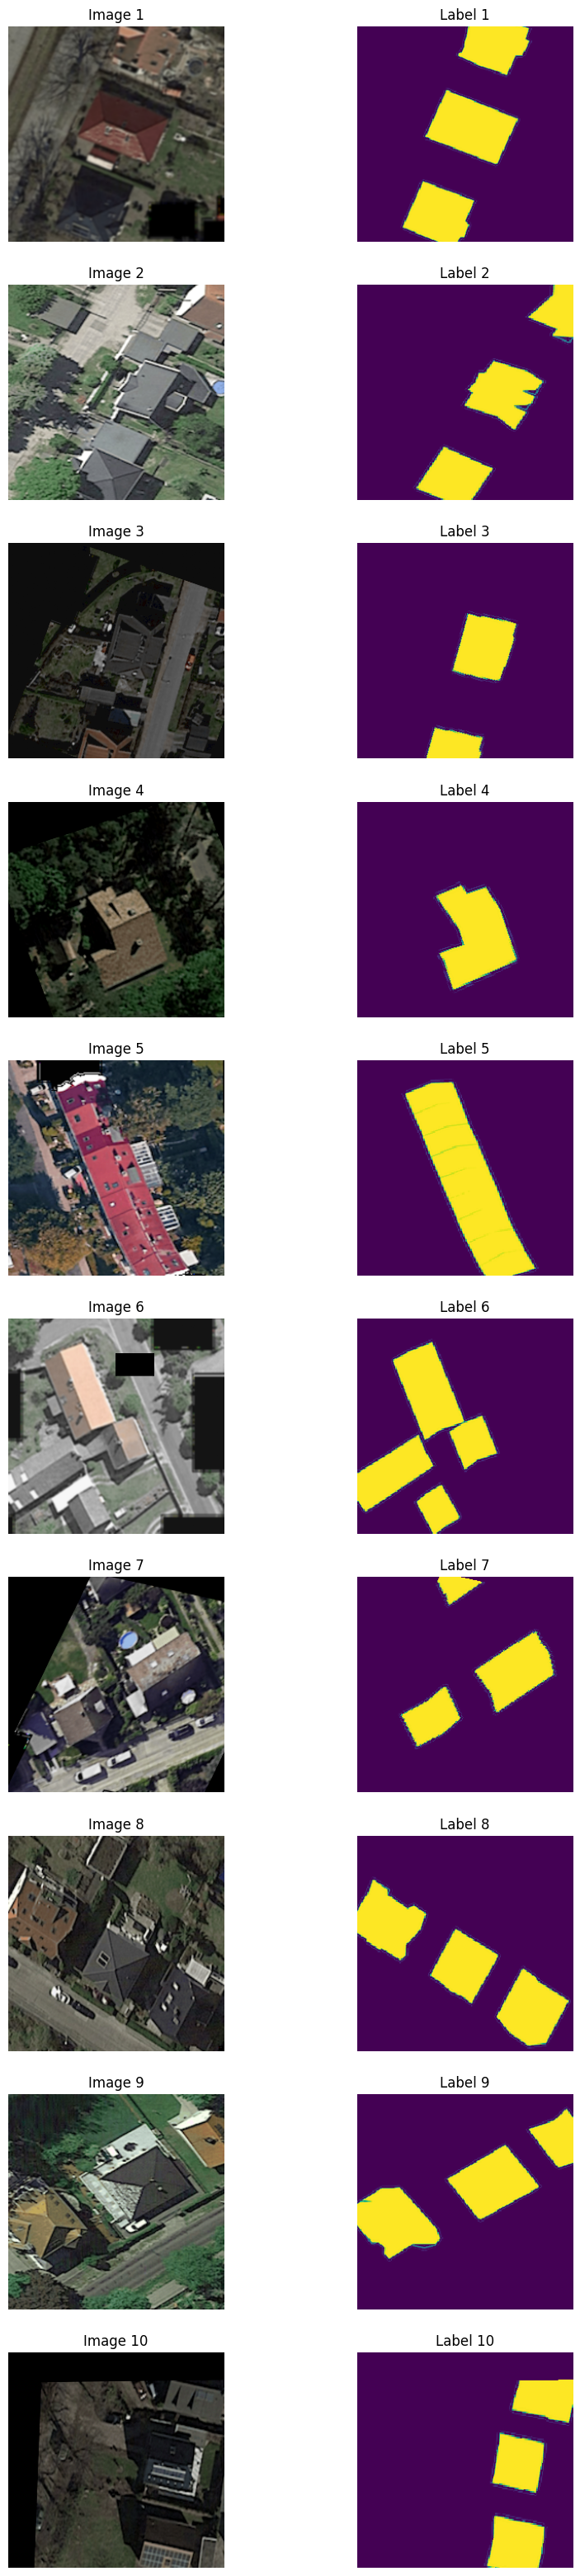

In [ ]:
# @title
print('Check the structure of the augmented dataset')
batch0 = next(iter(aug_loader))

print("Image batch shape: ", batch0[0].shape)
print("Label batch shape: ", batch0[1].shape)

images_to_display = 10
plt.figure(figsize=(10, 40))
for idx in range(images_to_display):
    # Display image
    plt.subplot(images_to_display, 2, 2*idx + 1)
    # Change dimensions from (C, H, W) to (H, W, C) for displaying
    plt.imshow(np.transpose(batch0[0][idx].numpy(), (1, 2, 0)))
    plt.title(f"Image {idx + 1}")
    plt.axis('off')

    # Display label
    plt.subplot(images_to_display, 2, 2*idx + 2)
    # Change dimensions from (C, H, W) to (H, W, C) for displaying
    plt.imshow(np.transpose(batch0[1][idx].numpy(), (1, 2, 0)))
    plt.title(f"Label {idx + 1}")
    plt.axis('off')

plt.show()

# Control model

I train the control model for 1000 epochs.

In [ ]:
# @title
print('Training loop for the control model without augmentations')
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model
control = smp.UPerNet(
    encoder_name="mit_b5",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid'
)

# Move the model to the device
control.to(device)

# Define the optimizer
optimizer = optim.Adam(control.parameters(), lr=1e-4)

# Define the loss function
dice_loss = DiceLoss(mode="binary")
focal_loss = FocalLoss(mode="binary")
log_dice_loss = DiceLoss(mode="binary", log_loss=True)
bce_loss = SoftBCEWithLogitsLoss()
loss_function = lambda outputs, labels: bce_loss(outputs, labels) + log_dice_loss(outputs, labels)

num_epochs = 1000

control_losses = []
control_dices = []
control_focals = []
control_bces = []
control_accuracies = []
control_f1_scores = []

for epoch in range(num_epochs):
    # Set the model to training mode
    control.train()

    running_loss = 0.0
    running_dice = 0.0
    running_focal = 0.0
    running_bce = 0.0
    running_accuracy = 0.0
    running_f1 = 0.0

    for i, (images, labels) in enumerate(control_loader):
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = control(images)

        # Calculate the loss
        loss = loss_function(outputs, labels)

        # Calculate other metrics
        batch_dice = 1.0 - dice_loss(outputs, labels)
        batch_focal = focal_loss(outputs, labels)
        batch_bce = bce_loss(outputs, labels)

        labels_long = labels.long()
        tp, fp, fn, tn = get_stats(outputs, labels_long, mode="binary", threshold=0.5)
        batch_accuracy = accuracy(tp, fp, fn, tn).mean()
        batch_f1 = f1_score(tp, fp, fn, tn).mean()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item()
        running_focal += batch_focal.item()
        running_bce += batch_bce.item()
        running_dice += batch_dice.item()
        running_accuracy += batch_accuracy.item()
        running_f1 += batch_f1.item()

    control_losses.append(running_loss / len(control_loader))
    control_focals.append(running_focal / len(control_loader))
    control_bces.append(running_bce / len(control_loader))
    control_dices.append(running_dice / len(control_loader))
    control_accuracies.append(running_accuracy / len(control_loader))
    control_f1_scores.append(running_f1 / len(control_loader))

    # Print metrics every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] finished. Loss: {control_losses[-1]:.4f}, Dice: {control_dices[-1]:.4f}, Focal: {control_focals[-1]:.4f}, BCE: {control_bces[-1]:.4f}, Accuracy: {control_accuracies[-1]:.4f}, F1: {control_f1_scores[-1]:.4f}')

print('Finished Training')
print(f'Final Results: Loss: {control_losses[-1]:.4f}, Dice: {control_dices[-1]:.4f}, Focal: {control_focals[-1]:.4f}, BCE: {control_bces[-1]:.4f}, Accuracy: {control_accuracies[-1]:.4f}, F1: {control_f1_scores[-1]:.4f}')

Training loop for the control model without augmentations
Using device: cuda
Epoch [100/1000] finished. Loss: 1.8370, Dice: 0.3062, Focal: 0.1607, BCE: 0.6536, Accuracy: 0.9698, F1: 0.8872
Epoch [200/1000] finished. Loss: 1.8271, Dice: 0.3077, Focal: 0.1570, BCE: 0.6484, Accuracy: 0.9754, F1: 0.9053
Epoch [300/1000] finished. Loss: 1.8230, Dice: 0.3084, Focal: 0.1559, BCE: 0.6467, Accuracy: 0.9762, F1: 0.9083
Epoch [400/1000] finished. Loss: 1.8207, Dice: 0.3088, Focal: 0.1553, BCE: 0.6457, Accuracy: 0.9765, F1: 0.9088
Epoch [500/1000] finished. Loss: 1.8194, Dice: 0.3090, Focal: 0.1548, BCE: 0.6450, Accuracy: 0.9774, F1: 0.9125
Epoch [600/1000] finished. Loss: 1.8181, Dice: 0.3092, Focal: 0.1542, BCE: 0.6442, Accuracy: 0.9787, F1: 0.9174
Epoch [700/1000] finished. Loss: 1.8173, Dice: 0.3093, Focal: 0.1540, BCE: 0.6438, Accuracy: 0.9793, F1: 0.9191
Epoch [800/1000] finished. Loss: 1.8164, Dice: 0.3095, Focal: 0.1539, BCE: 0.6436, Accuracy: 0.9787, F1: 0.9173
Epoch [900/1000] finished. 

Plot the resultant metrics for the training of the control model


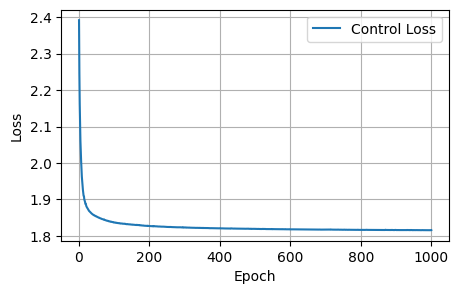

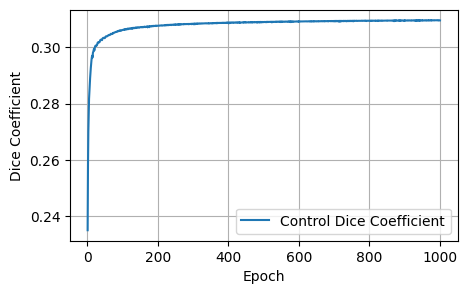

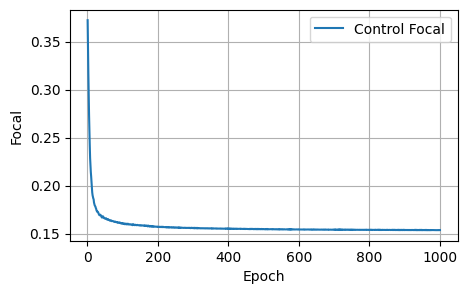

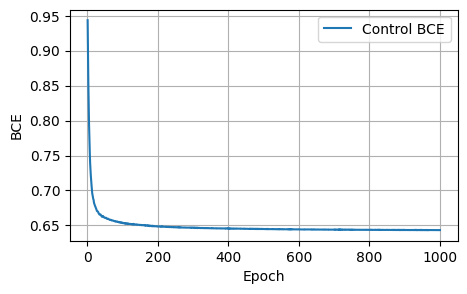

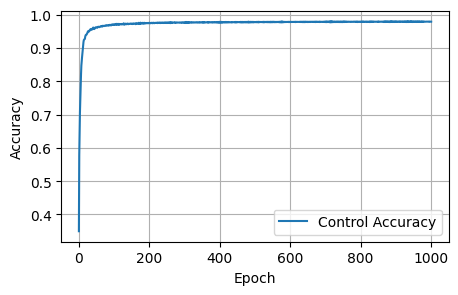

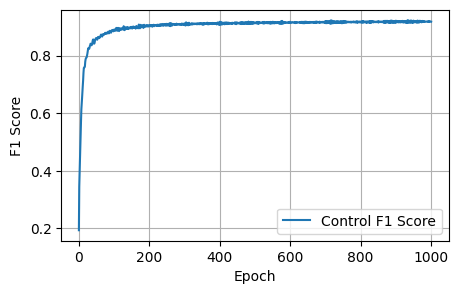

In [ ]:
# @title
print('Plot the resultant metrics for the training of the control model')
control_data = {
    'Epoch': range(1, len(control_losses) + 1),
    'Control Loss': control_losses,
    'Control Dice': control_dices,
    'Control Focal': control_focals,
    'Control BCE': control_bces,
    'Control Accuracy': control_accuracies,
    'Control F1 Score': control_f1_scores,
}

control_metrics_df = pd.DataFrame(control_data)

def plot_metrics(control_metrics, metric_name):
    epochs = range(1, len(control_metrics) + 1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, control_metrics, label=f'Control {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(control_losses, 'Loss')
plot_metrics(control_dices, 'Dice Coefficient')
plot_metrics(control_focals, 'Focal')
plot_metrics(control_bces, 'BCE')
plot_metrics(control_accuracies, 'Accuracy')
plot_metrics(control_f1_scores, 'F1 Score')

# Model trained on augmented data

I train a model on the dataset augmented with transformations from the AlbumentationsX library, increasing the size x10. I train it for 100 epochs. Here I also keep track of the metrics for the original unaugmented dataset.

In [ ]:
# @title
print('Training loop for the model with the augmented dataset')
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model
model = smp.UPerNet(
    encoder_name="mit_b5",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid'
)

# Move the model to the device
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define the loss function
dice_loss = DiceLoss(mode="binary")
focal_loss = FocalLoss(mode="binary")
log_dice_loss = DiceLoss(mode="binary", log_loss=True)
bce_loss = SoftBCEWithLogitsLoss()
loss_function = lambda outputs, labels: bce_loss(outputs, labels) + log_dice_loss(outputs, labels)

num_epochs = 100

aug_losses = []
aug_dices = []
aug_focals = []
aug_bces = []
aug_accuracies = []
aug_f1_scores = []

unaug_losses = []
unaug_dices = []
unaug_focals = []
unaug_bces = []
unaug_accuracies = []
unaug_f1_scores = []

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    running_loss = 0.0
    running_dice = 0.0
    running_focal = 0.0
    running_bce = 0.0
    running_accuracy = 0.0
    running_f1 = 0.0

    for i, (images, labels) in enumerate(aug_loader):
        # Move data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = loss_function(outputs, labels)

        # Calculate other metrics
        batch_dice = 1.0 - dice_loss(outputs, labels)
        batch_focal = focal_loss(outputs, labels)
        batch_bce = bce_loss(outputs, labels)

        labels_long = labels.long()
        tp, fp, fn, tn = get_stats(outputs, labels_long, mode="binary", threshold=0.5)
        batch_accuracy = accuracy(tp, fp, fn, tn).mean()
        batch_f1 = f1_score(tp, fp, fn, tn).mean()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item()
        running_focal += batch_focal.item()
        running_bce += batch_bce.item()
        running_dice += batch_dice.item()
        running_accuracy += batch_accuracy.item()
        running_f1 += batch_f1.item()

    aug_losses.append(running_loss / len(aug_loader))
    aug_focals.append(running_focal / len(aug_loader))
    aug_bces.append(running_bce / len(aug_loader))
    aug_dices.append(running_dice / len(aug_loader))
    aug_accuracies.append(running_accuracy / len(aug_loader))
    aug_f1_scores.append(running_f1 / len(aug_loader))

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] finished. Augmentation Loss: {aug_losses[-1]:.4f}, Augmentation Dice: {aug_dices[-1]:.4f}, Augmentation Focals: {aug_focals[-1]:.4f}, Augmentation BCE: {aug_bces[-1]:.4f}, Augmentation Accuracy: {aug_accuracies[-1]:.4f}, Augmentation F1: {aug_f1_scores[-1]:.4f}')

    # Evaluation loop after each epoch
    # Set the model to evaluation mode
    model.eval()
    unaug_loss = 0.0
    unaug_dice = 0.0
    unaug_focal = 0.0
    unaug_bce = 0.0
    unaug_accuracy = 0.0
    unaug_f1 = 0.0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for images, labels in control_loader:
            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_function(outputs, labels)

            # Calculate other metrics
            batch_dice = 1.0 - DiceLoss(mode="binary")(outputs, labels)
            batch_focal = FocalLoss(mode="binary")(outputs, labels)
            batch_bce = SoftBCEWithLogitsLoss()(outputs, labels)

            labels_long = labels.long()
            tp, fp, fn, tn = get_stats(outputs, labels_long, mode="binary", threshold=0.5)
            batch_accuracy = accuracy(tp, fp, fn, tn).mean()
            batch_f1 = f1_score(tp, fp, fn, tn).mean()

            # Update running metrics
            unaug_loss += loss.item()
            unaug_dice += batch_dice.item()
            unaug_focal += batch_focal.item()
            unaug_bce += batch_bce.item()
            unaug_accuracy += batch_accuracy.item()
            unaug_f1 += batch_f1.item()

    unaug_losses.append(unaug_loss / len(control_loader))
    unaug_dices.append(unaug_dice / len(control_loader))
    unaug_focals.append(unaug_focal / len(control_loader))
    unaug_bces.append(unaug_bce / len(control_loader))
    unaug_accuracies.append(unaug_accuracy / len(control_loader))
    unaug_f1_scores.append(unaug_f1 / len(control_loader))

    # Print metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] finished. Unaugmented Loss:  {unaug_losses[-1]:.4f}, Unaugmented Dice:  {unaug_dices[-1]:.4f}, Unaugmented Focals:  {unaug_focals[-1]:.4f}, Unaugmented BCE:  {unaug_bces[-1]:.4f}, Unaugmented Accuracy:  {unaug_accuracies[-1]:.4f}, Unaugmented F1:  {unaug_f1_scores[-1]:.4f}')

print('Finished Training')
print(f'Final Results: Augmentation Loss: {aug_losses[-1]:.4f}, Augmentation Dice: {aug_dices[-1]:.4f}, Augmentation Focals: {aug_focals[-1]:.4f}, Augmentation BCE: {aug_bces[-1]:.4f}, Augmentation Accuracy: {aug_accuracies[-1]:.4f}, Augmentation F1: {aug_f1_scores[-1]:.4f}')
print(f'               Unaugmented Loss:  {unaug_losses[-1]:.4f}, Unaugmented Dice:  {unaug_dices[-1]:.4f}, Unaugmented Focals:  {unaug_focals[-1]:.4f}, Unaugmented BCE:  {unaug_bces[-1]:.4f}, Unaugmented Accuracy:  {unaug_accuracies[-1]:.4f}, Unaugmented F1:  {unaug_f1_scores[-1]:.4f}')

Training loop for the model with the augmented dataset
Using device: cuda
Epoch [10/100] finished. Augmentation Loss: 1.8104, Augmentation Dice: 0.3166, Augmentation Focals: 0.1662, Augmentation BCE: 0.6592, Augmentation Accuracy: 0.9543, Augmentation F1: 0.8399
Epoch [10/100] finished. Unaugmented Loss:  1.8556, Unaugmented Dice:  0.3025, Unaugmented Focals:  0.1652, Unaugmented BCE:  0.6598, Unaugmented Accuracy:  0.9601, Unaugmented F1:  0.8525
Epoch [20/100] finished. Augmentation Loss: 1.7964, Augmentation Dice: 0.3193, Augmentation Focals: 0.1620, Augmentation BCE: 0.6532, Augmentation Accuracy: 0.9609, Augmentation F1: 0.8619
Epoch [20/100] finished. Unaugmented Loss:  1.8444, Unaugmented Dice:  0.3037, Unaugmented Focals:  0.1599, Unaugmented BCE:  0.6528, Unaugmented Accuracy:  0.9703, Unaugmented F1:  0.8860
Epoch [30/100] finished. Augmentation Loss: 1.7995, Augmentation Dice: 0.3171, Augmentation Focals: 0.1597, Augmentation BCE: 0.6505, Augmentation Accuracy: 0.9659, Augme

Plot the resultant metrics for the training of the model on augmented data


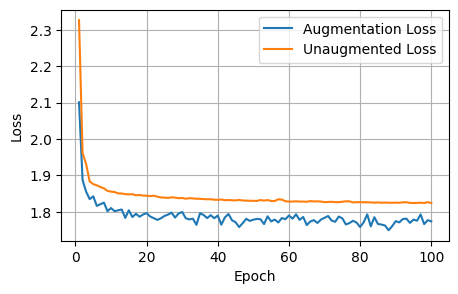

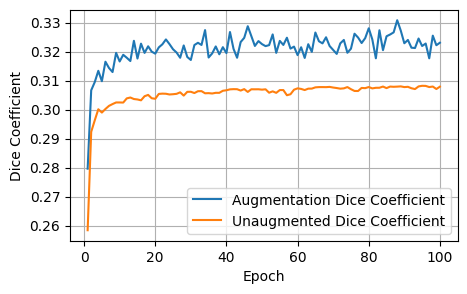

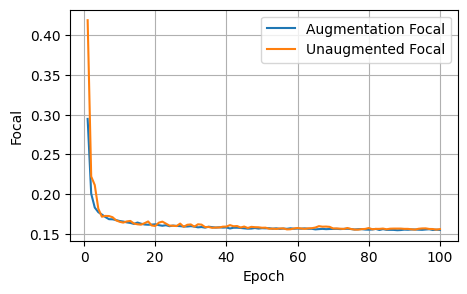

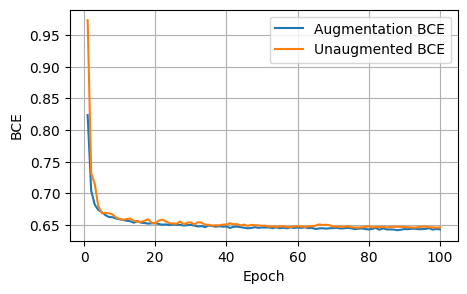

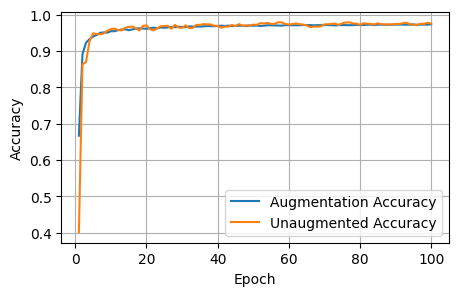

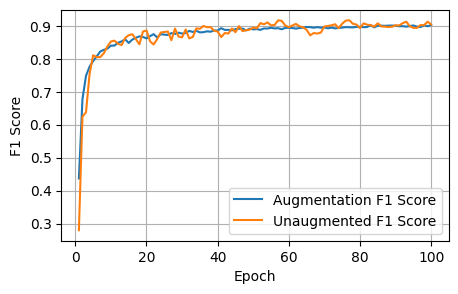

In [ ]:
# @title
print('Plot the resultant metrics for the training of the model on augmented data')
data = {
    'Epoch': range(1, len(aug_losses) + 1),
    'Augmentation Loss': aug_losses,
    'Augmentation Dice': aug_dices,
    'Augmentation Focal': aug_focals,
    'Augmentation BCE': aug_bces,
    'Augmentation Accuracy': aug_accuracies,
    'Augmentation F1 Score': aug_f1_scores,
    'Unaugmented Loss': unaug_losses,
    'Unaugmented Dice': unaug_dices,
    'Unaugmented Focal': unaug_focals,
    'Unaugmented BCE': unaug_bces,
    'Unaugmented Accuracy': unaug_accuracies,
    'Unaugmented F1 Score': unaug_f1_scores,
}

metrics_df = pd.DataFrame(data)

def plot_metrics(aug_metrics, unaug_metrics, metric_name):
    epochs = range(1, len(aug_metrics) + 1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, aug_metrics, label=f'Augmentation {metric_name}')
    plt.plot(epochs, unaug_metrics, label=f'Unaugmented {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(aug_losses, unaug_losses, 'Loss')
plot_metrics(aug_dices, unaug_dices, 'Dice Coefficient')
plot_metrics(aug_focals, unaug_focals, 'Focal')
plot_metrics(aug_bces, unaug_bces, 'BCE')
plot_metrics(aug_accuracies, unaug_accuracies, 'Accuracy')
plot_metrics(aug_f1_scores, unaug_f1_scores, 'F1 Score')

# Conclusions

After 1000 epochs, the control model had the following scores:
- Loss: 1.8157, Dice: 0.3096, Focal: 0.1537, BCE: 0.6433, Accuracy: 0.9788, F1: 0.9176

After 100 epochs, the model trained on augmented data had the following scores on the unaugmented dataset:
- Loss:  1.8244, Dice:  0.3079, Focals:  0.1559, BCE:  0.6465, Accuracy:  0.9750, F1:  0.9041

Clearly for our specific model, image augmentations did not improve the model performance across any of the metrics.

# Final predictions

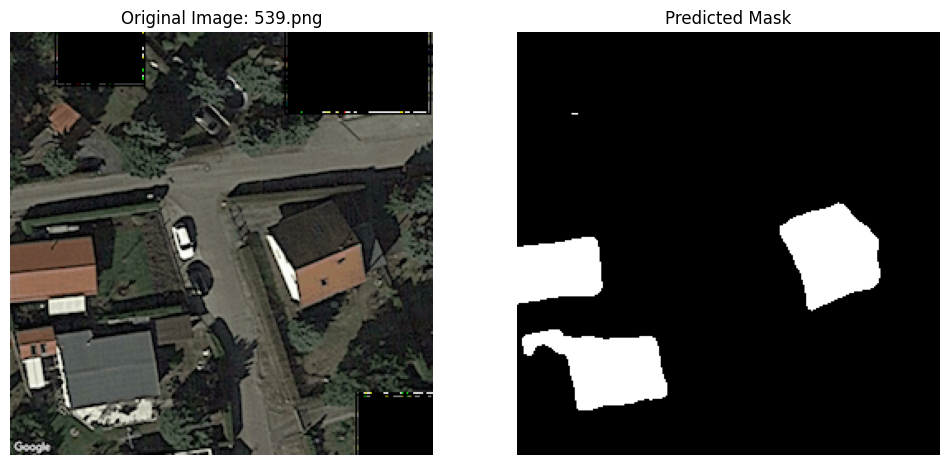

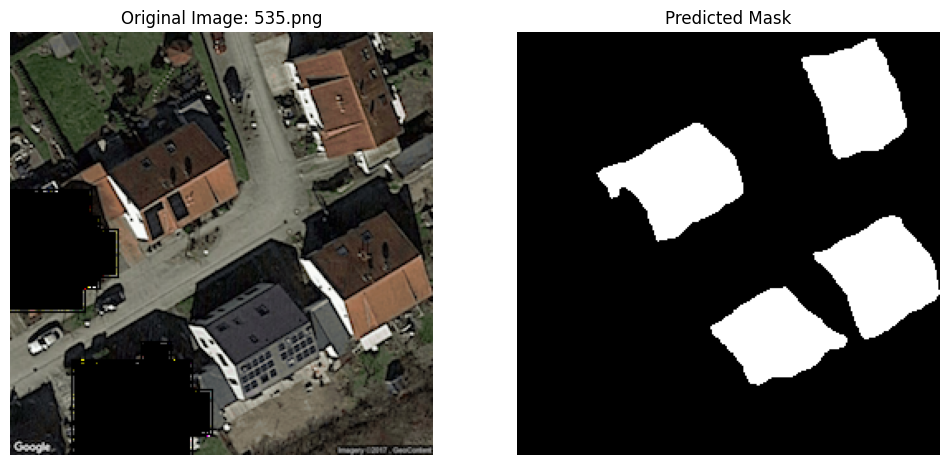

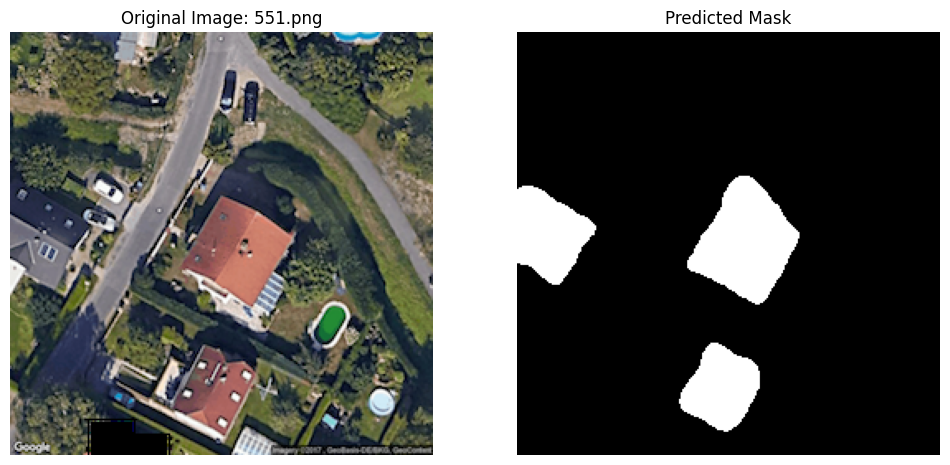

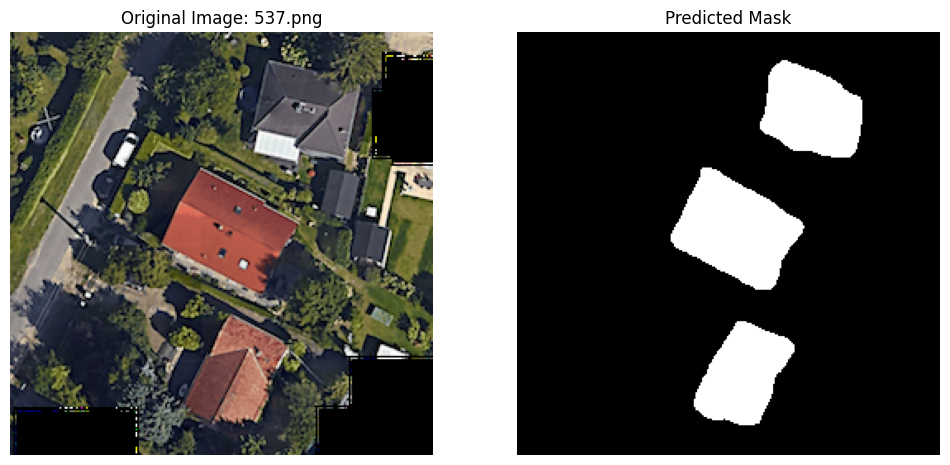

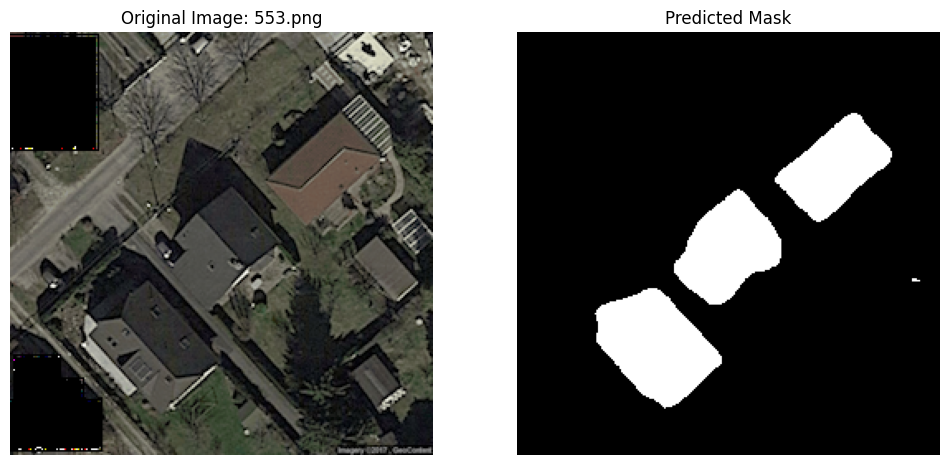

In [ ]:
predictions_dir = "/content/predictions"
os.makedirs(predictions_dir, exist_ok=True)
images_to_predict_files = os.listdir(to_predict)

control.eval()

for image_file in images_to_predict_files:
    image_path = os.path.join(to_predict, image_file)

    # Load and preprocess the image
    image_pil = Image.open(image_path).convert("RGB")
    image_tensor = ToTensor()(image_pil).unsqueeze(0).to(device)

    # Predict with the final model
    with torch.no_grad():
        prediction = control(image_tensor)

    # Process the prediction
    predicted_mask = (prediction.squeeze(0).cpu().numpy() > 0.5).astype(np.uint8)

    # Scale the predicted mask to 0-255, this is necessary for visualization apparently, as the white pixels are otherwise indicated by the value '1', indistinguisable from black at '0'.
    predicted_mask_scaled = predicted_mask * 255

    # Save the predicted mask
    mask_filename = f"prediction_{os.path.splitext(image_file)[0]}.png"
    mask_path = os.path.join(predictions_dir, mask_filename)
    Image.fromarray(predicted_mask_scaled.squeeze()).save(mask_path)

    # Display the original image and the predicted mask side-by-side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(image_pil))
    plt.title(f"Original Image: {image_file}")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask_scaled.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()